# HW08

## Exercises to practice pandas, data analysis, regression and classification

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from os import listdir, path
from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url
from data_utils import StandardScaler
from data_utils import LFWUtils
from data_utils import LinearRegression, RandomForestClassifier, SVC
from data_utils import classification_error, display_confusion_matrix, regression_error

from image_utils import make_image, open_image

from HW08_utils import CamUtils

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02).

This is the dataset that has anthropometric information about U.S. Army personnel.

In [3]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

#### Nested data

This is that *nested* dataset from Week 02.

# 🤔

Let's load it into a `DataFrame` to see what happens.

In [4]:
# Read into DataFrame
ansur_df = pd.DataFrame.from_records(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear,foot,hand,head
0,18,F,66,135,1699,1645,"{'breadth': 30, 'length': 61, 'protrusion': 20}","{'breadth': 97, 'length': 243}","{'breadth': 78, 'length': 182, 'palm': 108}","{'height': 243, 'circumference': 557}"
1,30,M,68,207,1749,1715,"{'breadth': 35, 'length': 63, 'protrusion': 17}","{'breadth': 100, 'length': 252}","{'breadth': 87, 'length': 184, 'palm': 114}","{'height': 238, 'circumference': 560}"
2,27,M,67,121,1684,1657,"{'breadth': 36, 'length': 59, 'protrusion': 24}","{'breadth': 92, 'length': 251}","{'breadth': 84, 'length': 180, 'palm': 103}","{'height': 239, 'circumference': 516}"
3,20,M,73,185,1878,1828,"{'breadth': 36, 'length': 60, 'protrusion': 21}","{'breadth': 104, 'length': 280}","{'breadth': 95, 'length': 201, 'palm': 124}","{'height': 270, 'circumference': 582}"
4,33,M,76,150,1977,1883,"{'breadth': 39, 'length': 65, 'protrusion': 27}","{'breadth': 101, 'length': 271}","{'breadth': 90, 'length': 194, 'palm': 113}","{'height': 254, 'circumference': 559}"



# 😓🙄

That didn't work too well. We ended up with objects in our columns.

Luckily, our `DataFrame` library has a function called [`json_normalize()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) that can help.

In [5]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


Much better. `DataFrames` are magic.

#### Data Exploration

Before we start creating models, let's do a little bit of data analysis and get a feeling for the shapes, distributions and relationships of our data.

1. Print `min`, `max` and `average` values for all of the features.
2. Print `covariance` tables for `age`, `ear.length` and `head.circumference`.
3. Plot `age`, `ear.length` and `head.circumference` versus the $1$ *feature* that is most correlated to each of them.

Don't forget to *encode* and *normalize* the data.

Available columns in ansur_df:
 Index(['age', 'gender', 'height', 'weight', 'span', 'stature', 'ear.breadth',
       'ear.length', 'ear.protrusion', 'foot.breadth', 'foot.length',
       'hand.breadth', 'hand.length', 'hand.palm', 'head.height',
       'head.circumference'],
      dtype='object')
Minimum values for each feature:
 age                     17
gender                   0
height                  56
weight                   0
span                  1323
stature               1409
ear.breadth             25
ear.length              46
ear.protrusion          13
foot.breadth            77
foot.length            198
hand.breadth            67
hand.length            145
hand.palm               88
head.height            206
head.circumference     502
dtype: int64
Maximum values for each feature:
 age                     58
gender                   0
height                  94
weight                 321
span                  2121
stature               1993
ear.breadth             46


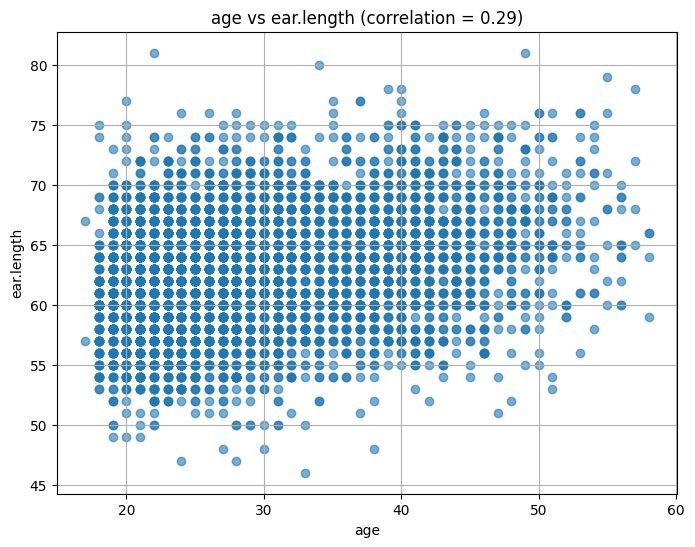

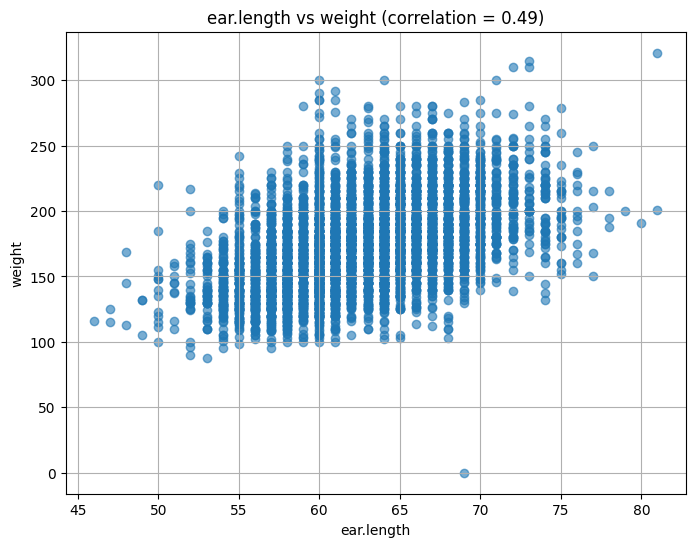

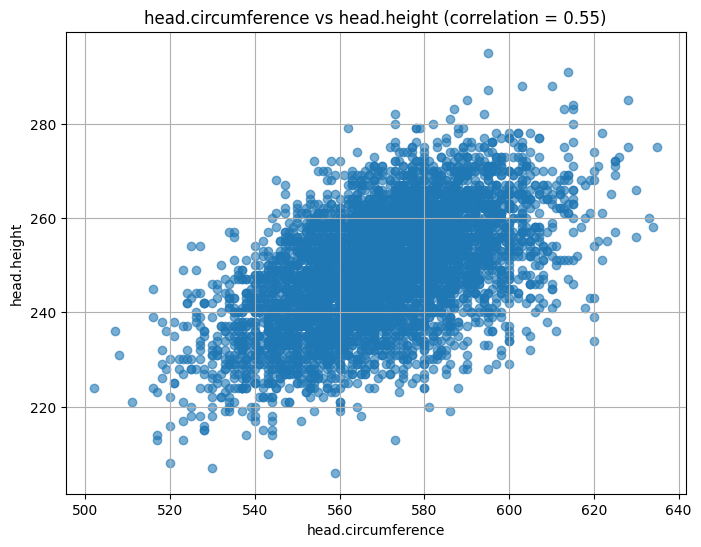

In [ ]:
# Work on Data Exploration here
print("Available columns in ansur_df:\n", ansur_df.columns)
### Encode non-numerical features
ansur_df['gender'] = ansur_df['gender'].apply(lambda x: 1 if x == 'F' else 0)

## 1. Print min, max, avg
numeric_df = ansur_df.select_dtypes(include=['float64', 'int64'])

min_features = numeric_df.min()
max_features = numeric_df.max()
avg_features = numeric_df.mean()

print("Minimum values for each feature:\n", min_features)
print("Maximum values for each feature:\n", max_features)
print("Average values for each feature:\n", avg_features)

### Normalize all data
normalized_df = (numeric_df - min_features) / (max_features - min_features)
print("Normalized data:\n", normalized_df.head())

## 2. Print Covariances
cov_matrix = numeric_df.cov()
print("Covariance matrix:\n", cov_matrix)

## 3. Plot features most correlated to age, ear length and head circumference
features_of_interest = ['age', 'ear.length', 'head.circumference']
features_of_interest = [feature for feature in features_of_interest if feature in numeric_df.columns]

correlation_matrix = numeric_df.corr()

# Check and plot correlations for each feature of interest
for feature in features_of_interest:
    most_correlated_feature = correlation_matrix[feature].drop(feature).idxmax()
    correlation_value = correlation_matrix[feature][most_correlated_feature]

    # Plot the scatter plot of feature vs its most correlated feature
    plt.figure(figsize=(8, 6))
    plt.scatter(numeric_df[feature], numeric_df[most_correlated_feature], alpha=0.6)
    plt.title(f"{feature} vs {most_correlated_feature} (correlation = {correlation_value:.2f})")
    plt.xlabel(feature)
    plt.ylabel(most_correlated_feature)
    plt.grid(True)
    plt.show()

### Interpretation

<span style="color:hotpink;">
Does anything stand out about these graphs? Or the correlations?<br>
Are correlations symmetric? Does the feature most correlated to ear length also have ear length as its most correlated pair?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

The feature most correlated with head.circumference is head.height.
The feature most correlated with ear.length is weight (correlation = 0.49)


### Regression
create a regression model to predict `head.circumference` from the data.
Now, we want to 

From our [Week 08](https://github.com/DM-GY-9103-2024F-H/WK08) notebook, we can create a regression model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (done! ⚡️)
3. Normalize the data (done! 🍾)
4. Separate the outcome variable and the input features
5. Create a regression model using all features
6. Run model on training data and measure error
7. Plot predictions and interpret results
8. Run model on test data, measure error, plot predictions, interpret results

In [ ]:
## Load Test Data
ANSUR_TEST_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/ansur-test.json"
ansur_test_data = object_from_json_url(ANSUR_TEST_FILE)
ansur_test_df = pd.json_normalize(ansur_test_data)

ansur_test_encoded_df = ansur_test_df.copy()

g_vals = ansur_encoder.transform(ansur_test_df[["gender"]].values)
ansur_test_encoded_df[["gender"]] = g_vals

ansur_test_scaled_df = ansur_scaler.transform(ansur_test_encoded_df)

In [ ]:
## Run model on test data

## Measure error on test data

## Plot predictions and interpret results

### Interpretation

<span style="color:hotpink;">
How well does your classifier perform?<br>
How could you improve it?<br>
Are there ranges of circumferences that don't get predicted well?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

## Classification

The dataset we are going to use has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

### Loading Data

If we look at the images in `./data/images/0801-500/train/`, we'll notice that they are named and organized in a very particular way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

In [ ]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/images/0801-500/train") if f.endswith(".jpg")]

In [ ]:
# TODO: check and see what is inside the list here

Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [ ]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = open_image(path.join("./data/images/0801-500/train", fname))
  pixel_data.append(img.pixels)
  label_data.append(label)

In [ ]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list

The labels and the filenames won't match exactly since labels start at $0$ and the filenames start at $01$ and skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly:

In [ ]:
display(make_image(pixel_data[0], width=256))
display(make_image(pixel_data[10], width=256))

And now might not be a bad time to peek into the `data/images/0801-500/` directories to see what's inside them and what the images look like.... and get to know the data...

### DataFrame it

Let's put our raw pixel data into a `DataFrame`, and create a column for storing each image's label.

(this next cell might take a while to run)

In [ ]:
train_df = pd.DataFrame(pixel_data)
train_df["label"] = label_data

Let's inspect our `DataFrame`:

In [ ]:
train_df.head()

### Test Files

If that worked, repeat the process for the test files inside the `./data/images/0801-500/test/` directory.

We can almost use the exact same steps as we did above to create a `DataFrame`, the only difference being that we don't have labels for these images.

In [ ]:
# TODO: create a list of files in the test/ directory
test_files = []

# TODO: check its length and content

test_pixel_data = []

# TODO: loop over files and load their pixels into a list

# TODO: load into DataFrame (this might take 20 - 30 seconds)

Check the `DataFrame`

In [ ]:
test_df.head()

Looks like data!!

We could train a `RandomForestClassifier` directly on this `DataFrame` and see what would happen, but my guess is that Python runs out of memory and crashes our tab/browser/computer...

We'll use _projection_ to reduce the number of dimensions in our dataset. Projection is when we just drop some of the columns in our dataset. 

Which columns ? That's up to us.

Let's first try using the first $N$ columns/features where $N$ is a number around $10$.

This is how we get the first $N$ columns from a `DataFrame`:

In [ ]:
# split input and output features
NUM_FEATURES = 10
chosen_columns = train_df.columns[:NUM_FEATURES]
train_features = train_df[chosen_columns]

out_features = train_df["label"]

# also separate test dataset features
test_features = test_df[chosen_columns]

From our [Week 08](https://github.com/DM-GY-9103-2024F-H/WK08) notebook, we can create a classification model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (not needed! done! ⚡️)
3. Normalize the data (not needed! done! 🍾)
4. Separate the outcome variable and the input features (done! ☀️)
5. Create a model using chosen features
6. Run model on training data and measure error
7. Run model on test data, measure error, plot predictions, interpret results

In [ ]:
# TODO: create a brand new classifier
# TODO: fit the model
# TODO: run predictions
# TODO: measure classification accuracy

That should look promising. Let's run this on our test dataset.

Remember we already separated the test data features into a variable called `test_features` above.

Now we just have to run the prediction and measure accuracy.

In [ ]:
# TODO: run predictions on test data
# TODO: measure classification accuracy

### Interpretation

Using just the first $10$ pixels of the image the classifier is able to label most of the images correctly.

<span style="color:hotpink">
How can we improve this classifier? How does the number of features affect the classification accuracy of the test data<br>
How does the choice of pixels affect the accuracy?<br><br>
Experiment with some of these parameters and explain your findings below.
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>